In [372]:
import cv2
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from mobile_sam.tracker import SamTracker, read_image
import glob
import PIL.Image

In [373]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


def read_image(path: str):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def down_to_64(x):
    return F.interpolate(x, (64, 64), mode="area")
def down_to_64_maxpool(x):
    x = F.max_pool2d(x, 3, 2, 1)
    x = F.max_pool2d(x, 3, 2, 1)
    return x

def up_to_256(x):
    return F.interpolate(x, (256, 256), mode="bilinear")

def mask_to_box(mask):
    mask = mask[0, 0] > 0
    mask = mask.detach().cpu().numpy()
    mask_pts = np.argwhere(mask)
    min_y = np.min(mask_pts[:, 0])
    min_x = np.min(mask_pts[:, 1])
    max_y = np.max(mask_pts[:, 0])
    max_x = np.max(mask_pts[:, 1])
    next_box = np.array([min_x, min_y, max_x, max_y])
    return next_box

class SamTracker:
    
    def __init__(self, checkpoint, token_history=1):
        model_type = "vit_t"
        sam_checkpoint = checkpoint
        device = "cuda" if torch.cuda.is_available() else "cpu"
        mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        mobile_sam.to(device=device)
        mobile_sam.eval()
        self.predictor = SamPredictor(mobile_sam)
        self._feature_buffer = []
        self._mask_buffer = []
        self._token_history = token_history

    def compute_features(self, image):
        self.predictor.set_image(image)
        return self.predictor.features
        
    def compute_features_and_mask(self, image, bbox):
        self.predictor.set_image(image)
        _, _, mask = self.predictor.predict(
            box=bbox,
            multimask_output=False
        )
        return self.predictor.features, torch.from_numpy(mask[None, ...]).cuda()

    def refine_mask(self, image, bbox, mask, scale=50., iters=2, set_image=True):
        if set_image:
            self.predictor.set_image(image)
        mask = scale * mask[0] # remove batch dim
        for i in range(iters):
            _, _, mask = self.predictor.predict(
                box=bbox,
                multimask_output=False,
                mask_input=mask
            )
            mask = mask * scale
        return torch.from_numpy(mask[None, ...]).cuda() # add batch dim

    def fit_lstsq_mask_token(self, features, mask):
        """
        Finds token that when dot-producted with features minimizes MSE with low 
        resolution masks.

        Args:
            features (Nx256x64x64)
            mask (Nx1x64x64) - Should be logits type
        """
        with torch.no_grad():
            W = mask.shape[2]
            N = features.shape[0]
            C = features.shape[1]
            assert N == mask.shape[0]
            A = features.permute(0, 2, 3, 1).reshape(N * W * W, C)
            B = mask.permute(0, 2, 3, 1).reshape(N * W * W, 1)
            B = torch.tanh(B * 10)
            X = torch.linalg.lstsq(A, B).solution.reshape(1, C, 1, 1)
        return X.detach()
    
    def apply_token(self, features, token):
        return torch.sum(features * token, dim=(1), keepdim=True)

    def init(self, image, bbox, refine_scale=1., refine_iters=1):
        scale = max(image.shape[0], image.shape[1]) / 256.
        features, mask = self.compute_features_and_mask(image, bbox)
        token = self.fit_lstsq_mask_token(features, down_to_64(mask))
        self.token = token
        mask_token = self.apply_token(features, token)
        mask_bbox = mask_to_box(mask_token) * scale
        mask_token_refined = self.refine_mask(image, mask_bbox, mask_token, scale=refine_scale, iters=refine_iters, set_image=False)
        self._feature_buffer = []
        self._mask_buffer = []
        self._feature_buffer.append(features)
        self._mask_buffer.append(down_to_64(mask_token_refined))
        return mask_bbox, mask_token_refined

    def update(self, image, refine_scale=1., refine_iters=1):
        if not hasattr(self, 'token'):
            raise RuntimeError("No token found.  Did you call tracker.init()?")
        scale = max(image.shape[0], image.shape[1]) / 256.
        features = self.compute_features(image)
        mask_token = self.apply_token(features, self.token)
        mask_bbox = mask_to_box(mask_token) * scale
        mask_token_refined = self.refine_mask(image, mask_bbox, mask_token, scale=refine_scale, iters=refine_iters)
        reg_f = torch.cat(self._feature_buffer, dim=0)
        mask_f = torch.cat(self._mask_buffer, dim=0)
        self.token = self.fit_lstsq_mask_token(reg_f, mask_f)
        self._feature_buffer.append(features)
        self._mask_buffer.append(down_to_64(mask_token_refined))
        if len(self._feature_buffer) > self._token_history:
            self._feature_buffer = self._feature_buffer[1:]
            self._mask_buffer = self._mask_buffer[1:]
        return mask_bbox, mask_token_refined

In [374]:
tracker = SamTracker("../weights/mobile_sam.pt")

In [382]:
box = [350, 460, 470, 620]

def compute_roi(box, scale=1.5):
    boxw = box[2] - box[0]
    boxh = box[3] - box[1]
    rcx = int(box[0] + boxw / 2)
    rcy = int(box[1] + boxh / 2)

    if boxw > boxh:
        s = int(scale * boxw)
    else:
        s = int(scale * boxh)
    roi = [rcx - s//2, rcy - s//2, rcx - s//2 + s, rcy - s//2 + s]
    box_in_roi = [
        box[0] - roi[0],
        box[1] - roi[1],
        box[2] - roi[0],
        box[3] - roi[1]
    ]
    return roi, box_in_roi

def crop_img(image, roi):
    image_pil = PIL.Image.fromarray(image)
    # roiw = roi[2] - roi[0]
    # roih = roi[3] - roi[1]
    image_pil = image_pil.crop(roi)
    return np.asarray(image_pil)

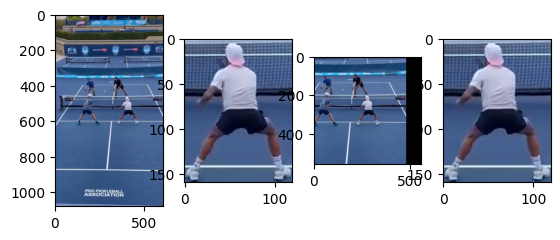

In [381]:

image_paths = sorted(glob.glob("../data/pickleball_video/images/*.png"))
image = read_image(image_paths[0])
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(crop_img(image, box))
plt.subplot(143)
roi, box2roi = compute_roi(box, 3.5)
img_roi = crop_img(image, roi)
img_box_roi = crop_img(img_roi, box2roi)
plt.imshow(img_roi)
plt.subplot(144)
plt.imshow(img_box_roi)
plt.show()

In [383]:
image_paths = sorted(glob.glob("../data/pickleball_video/images/*.png"))
image = read_image(image_paths[0])
box = [350, 460, 470, 620]
roi, box_roi = compute_roi(box, scale=1.5)
image_roi = crop_img(image, roi)
features, mask = tracker.compute_features_and_mask(image_roi, np.array(box_roi))

In [384]:
mask = down_to_64(mask)
W = mask.shape[2]
N = features.shape[0]
C = features.shape[1]
assert N == mask.shape[0]
A = features.permute(0, 2, 3, 1).reshape(N * W * W, C)
B = mask.permute(0, 2, 3, 1).reshape(N * W * W, 1)

In [356]:


def down_to_64n(x):
    return F.interpolate(x, (64, 64), mode="nearest")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


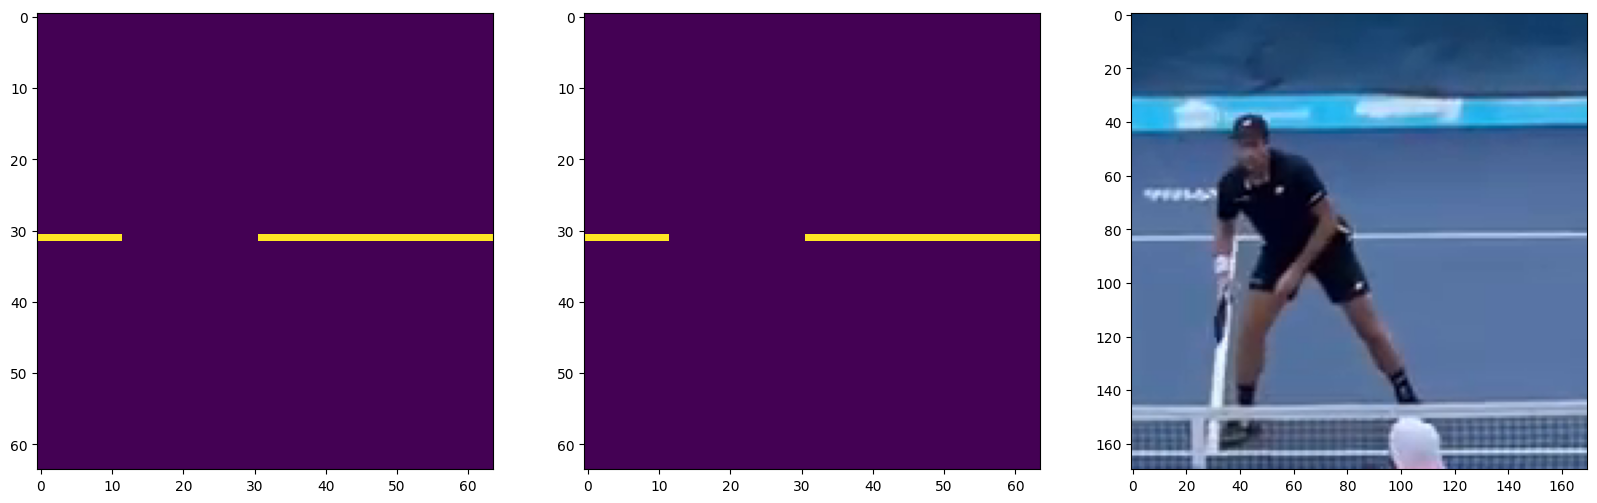

ValueError: zero-size array to reduction operation minimum which has no identity

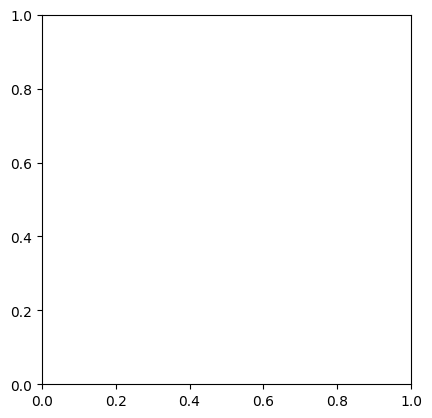

In [411]:
import sklearn.svm as sksvm

svm = sksvm.LinearSVC()

image_paths = sorted(glob.glob("../data/pickleball_video/images/*.png"))
image = read_image(image_paths[0])
box_1 = [350, 460, 470, 620]
box_2 = [300, 400, 470, 400]


box = box_2
roi, box_roi = compute_roi(box, scale=1)
image_roi = crop_img(image, roi)
features, mask = tracker.compute_features_and_mask(image_roi, np.array(box_roi))
token = tracker.fit_lstsq_mask_token(features, down_to_64(mask))
mask_token = tracker.apply_token(features, token)

mask = down_to_64(mask)
W = mask.shape[2]
N = features.shape[0]
C = features.shape[1]
assert N == mask.shape[0]
A = features.permute(0, 2, 3, 1).reshape(N * W * W, C)
B = mask.permute(0, 2, 3, 1).reshape(N * W * W, 1)
svm.fit(A.detach().cpu().numpy(), B.detach().cpu().numpy() > 0)

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(mask[0, 0].detach().cpu() > 0)
# plt.subplot(132)
# plt.imshow(mask_token[0,0].detach().cpu())
mask_a = svm.predict(A.detach().cpu().numpy()).reshape((64, 64))
plt.subplot(132)
plt.imshow(mask_a)
plt.subplot(133)
plt.imshow(image_roi)
plt.show()
# plt.imshow(crop_img(image, box))
# plt.show()



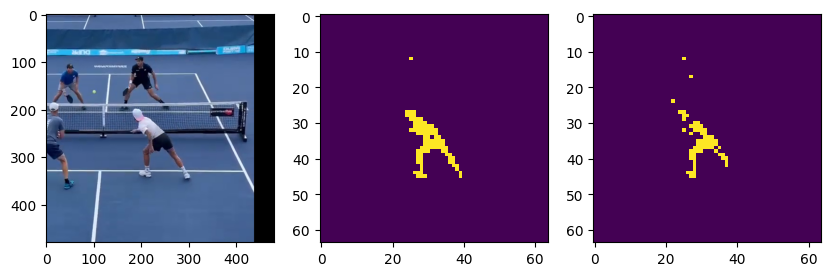

In [402]:
import time
from IPython.display import clear_output

for i in range(0, 300, 10):
    image = read_image(image_paths[i])
    image_roi = crop_img(image, roi)
    features, mask = tracker.compute_features_and_mask(image_roi, np.array(box_roi))
    A = features.permute(0, 2, 3, 1).reshape(N * W * W, C)

    mask_b = svm.predict(A.detach().cpu().numpy()).reshape((64, 64))
    mask_c = tracker.apply_token(features, token)[0,0].detach().cpu()
    clear_output()
    # plt.subplot(133)
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(image_roi)
    plt.subplot(132)
    plt.imshow(mask_b)
    plt.subplot(133)
    plt.imshow(mask_c > 0)
    plt.show()
    time.sleep(0.3)
    
# mask_token = tracker.apply_token(features, token)
# plt.subplot(133)
# plt.imshow(mask_token[0,0].detach().cpu())
# plt.show()

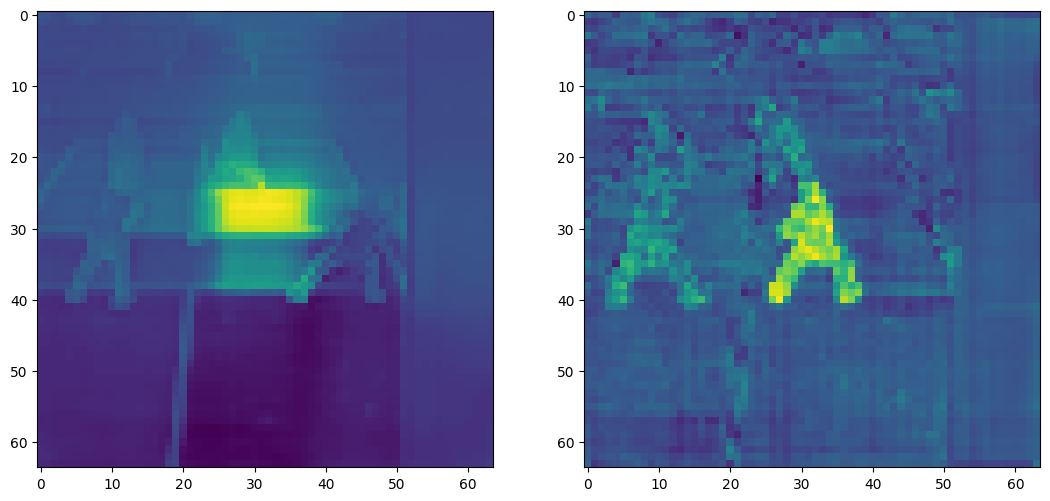

In [354]:
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(down_to_64(mask)[0,0].detach().cpu())
# plt.colorbar()
plt.subplot(132)
plt.imshow(mask_token[0,0].detach().cpu())
# plt.colorbar()
# plt.subplot(133)
# plt.imshow(torch.abs(mask_token[0,0] - mask_token2[0,0]).detach().cpu())
# plt.colorbar()
plt.show()

In [21]:
import cv2
image_paths = sorted(glob.glob("../data/pickleball_video/images/*.png"))
# cap = cv2.VideoCapture(0)
video_writer = cv2.VideoWriter('../data/person_10.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (640, 480))

# head_box = np.array([420, 100, 620, 400])
box = [350, 460, 470, 620]
# re, img = cap.read()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = read_image(image_paths[0])
bbox, mask = tracker.init(img, np.array(box))
for i in tqdm.tqdm(range(1, len(image_paths))):
    img = read_image(image_paths[i])
    bbox, mask = tracker.update(img, refine_iters=1)
    mask = mask.detach().cpu().numpy()[0, 0] > 0
    mask = mask.astype(np.uint8) * 255
    mask = np.stack([mask, mask, mask], axis=-1)
    mask = cv2.resize(mask, (640, 640))[:480, :, :]
    # mask = cv2.resize(mask, (640, 480))
    img[mask == 0] = 0
    img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    video_writer.write(img)
video_writer.release()

ValueError: zero-size array to reduction operation minimum which has no identity

In [561]:
video_writer = cv2.VideoWriter('../data/pickleball.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (256, 256))
bbox, mask = tracker.init(read_image(image_paths[0]), np.array(box))
for i in tqdm.tqdm(range(1, len(image_paths))):
    bbox, mask = tracker.update(read_image(image_paths[i]), refine_iters=1)
    mask = mask.detach().cpu().numpy()[0, 0] > 0
    mask = mask.astype(np.uint8) * 255
    mask = np.stack([mask, mask, mask], axis=-1)
    # mask = cv2.resize(mask, (640, 480))
    video_writer.write(mask)
video_writer.release()

100%|██████████| 99/99 [00:08<00:00, 12.03it/s]


In [12]:

img = read_image(f"../data/images_track_1/frame_0.jpg")

In [1]:
import cv2

In [2]:
cap = cv2.VideoCapture("../data/pickleball_video/THAT is pickleball.mp4")

In [3]:
re, img = cap.read()

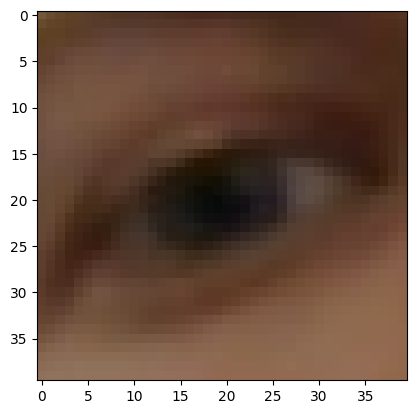

In [23]:
import matplotlib.pyplot as plt
plt.imshow(img[170:210, 460:500])
plt.show()

In [11]:
import cv2

# cap = cv2.VideoCapture(0)
video_writer = cv2.VideoWriter('../data/person_10.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (640, 480))

head_box = np.array([420, 100, 620, 400])
eye_box = np.array([460, 170, 500, 210])
# re, img = cap.read()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = read_image(f"../data/images_track_1/frame_0.jpg")
bbox, mask = tracker.init(img, np.array([420, 100, 620, 400]))
for i in tqdm.tqdm(range(1, 100)):
    img = read_image(f"../data/images_track_1/frame_{i}.jpg")
    bbox, mask = tracker.update(img, refine_iters=1)
    mask = mask.detach().cpu().numpy()[0, 0] > 0
    mask = mask.astype(np.uint8) * 255
    mask = np.stack([mask, mask, mask], axis=-1)
    mask = cv2.resize(mask, (640, 640))[:480, :, :]
    # mask = cv2.resize(mask, (640, 480))
    img[mask == 0] = 0
    img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    video_writer.write(img)
video_writer.release()
# cap.release()

100%|██████████| 99/99 [00:08<00:00, 11.56it/s]


In [7]:
img.

(480, 640, 3)